In [8]:
import sys
sys.path.append("../..")

from spanemo.learner import Trainer, EvaluateOnTest
from spanemo.model import SpanEmo
from spanemo.data_loader import DataClass, twitter_preprocessor
from data_selector import DataSelector
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
import json
import random

seed = 12345678
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda:0':
    print("Currently using GPU: {}".format(device))
else:
    print("WARNING: USING CPU")

Currently using GPU: cuda:0


In [10]:
preprocessor = twitter_preprocessor()

def make_loaders(args, data, batch_size, shuffle=True):
    dataset = DataClass(args, data, preprocessor=preprocessor)
    data_loader = DataLoader(dataset,
                             batch_size=int(batch_size),
                             shuffle=shuffle)

    print('The number of batches: ', len(data_loader))

    return data_loader

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


In [11]:
def make_model(args, bce_weight=None):
    model = SpanEmo(output_dropout=args['output_dropout'],
                    backbone=args['backbone'],
                    joint_loss=args['loss_type'],
                    alpha=args['alpha_loss'],
                    bce_weight=bce_weight,)
    
    return model


In [12]:
def pipeline(args, loaders=None):
    now = datetime.datetime.now()
    filename = now.strftime("%Y-%m-%d-%H:%M:%S")
    fw = open('configs/' + filename + '.json', 'a')
    json.dump(args, fw, sort_keys=True, indent=2)

    train_data_loader, val_data_loader = loaders

    bce_weight = args['bce_weight']
    if bce_weight == "auto": bce_weight = len(l := train_data_loader.dataset.labels) / l.sum(0) / 2
    model = make_model(args, bce_weight=bce_weight)

    learn = Trainer(model, train_data_loader, val_data_loader, filename=filename)
    learn.fit(
        num_epochs=int(args['max_epoch']),
        args=args,
        device=device
    )

In [13]:
hyperparams = {
    'train_path': 'data/train.csv', 
    'val_path': 'data/val.csv',
    'backbone': 'bert-base-uncased',
    'train_batch_size': 32,
    'val_batch_size': 32,
    'output_dropout': 0.1,
    'max_epoch': 10,
    'max_length': 512,
    'ffn_lr': 0.0003,
    'bert_lr': 1e-5,
    'loss_type': 'joint',
    'alpha_loss': 0.1,
    'bce_weight': 'auto',
}

In [14]:
assert False

AssertionError: 

## Train

In [15]:
def filter_neutrals(df):
    df.loc[:, "0":"10"] = (df.loc[:, "0":"10"] > 0).astype(int)
    df["filter"] = df.loc[:, "0":"10"].any(axis=1).astype(int)

    return df

In [16]:
ds = DataSelector("data.csv")
# train, val, tests = ds.select_data({"IEMOCAP": 1, "Cornell": 3, "Bolt": 3}, filter=filter_neutrals)
train, val, tests = ds.select_data(30000, filter=filter_neutrals, balance=True)

/home/alexlu/Documents/Programming/alexlu07/Scires/11th/model2/model/data_selector.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(filepath)


Filtering...
Calculating counts...
Grabbing data...


/tmp/ipykernel_14274/1817377494.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "0":"10"] = (df.loc[:, "0":"10"] > 0).astype(int)


In [17]:
train_loader = make_loaders(hyperparams, train, hyperparams['train_batch_size'])
val_loader = make_loaders(hyperparams, val, hyperparams['val_batch_size'])
loaders = (train_loader, val_loader)

100%|██████████| 24000/24000 [00:34<00:00, 696.16it/s]


The number of batches:  750


100%|██████████| 3000/3000 [00:04<00:00, 676.47it/s]


The number of batches:  94


In [18]:
#wooooooooooooooooooooo
pipeline(hyperparams, loaders=loaders)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future vers

Train_Loss,Val_Loss,F1-Macro,F1-Micro,JS,Time
0.8174,0.7937,0.3809,0.4344,0.3110,08:07
0.7857,0.7889,0.4279,0.4688,0.3532,08:08
0.7574,0.7849,0.4267,0.4563,0.3368,07:53
0.7262,0.7956,0.4135,0.4462,0.3323,07:59
0.6899,0.8426,0.4226,0.4520,0.3413,07:50
0.6509,0.8809,0.4185,0.4448,0.3343,07:54
0.6153,0.8987,0.4110,0.4443,0.3357,08:03


epoch#:  1
Validation loss decreased (inf --> 0.793731).  Saving model ...
epoch#:  2
Validation loss decreased (0.793731 --> 0.788865).  Saving model ...
epoch#:  3
Validation loss decreased (0.788865 --> 0.784942).  Saving model ...
epoch#:  4
EarlyStopping counter: 1 out of 5
epoch#:  5
EarlyStopping counter: 2 out of 5
epoch#:  6
EarlyStopping counter: 3 out of 5
epoch#:  7
EarlyStopping counter: 4 out of 5
epoch#:  8
EarlyStopping counter: 5 out of 5
Early stopping


In [ ]:
# pd.concat((train, val, tests)).loc[:, "0":].sum(0)

0      7766
1      9183
2      8000
3      3758
4     13333
5      4730
6     12118
7      4445
8      8123
9      3473
10     3383
dtype: int64

In [ ]:
# m = 0
# c = 0
# tc = 0
# for i in train_loader.dataset:
#     tc += 1
#     ma = i[0]['attention_mask'].sum()
#     if ma > 500:
#         # print(i[0]['input_ids'])
#         print(ma)
#         if ma > m: m = ma
#         c += 1

# print(m)
# print(c)
# print(tc)

## Test

In [19]:
def test(args, model_path, loader=None):

    if loader is None:
        test_data_loader = make_loaders(args, test=True)
    else:
        test_data_loader = loader

    model = make_model(args)
    
    learn = EvaluateOnTest(model, test_data_loader, model_path='models/' + model_path)
    return learn.predict(device=device), model

In [20]:
hyperparams['test_batch_size'] = 32

In [21]:
test_loader = make_loaders(hyperparams, tests, hyperparams['test_batch_size'], shuffle=False)

100%|██████████| 3000/3000 [00:04<00:00, 682.75it/s]


The number of batches:  94


In [22]:
preds, model = test(hyperparams, "2023-12-27-21:31:27_checkpoint.pt", loader=test_loader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


F1-Macro: 0.4232 F1-Micro: 0.4563 JS: 0.3407 Time: 00:20


In [ ]:
label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]

abc = np.concatenate((preds["y_true"], preds["y_pred"], preds["logits"]), axis=1)
d = pd.DataFrame(abc, columns=[name+suffix for suffix in ["_True", "_Pred", "_Logits"] for name in label_names])

In [ ]:
d.to_csv("abc.csv")

NameError: name 'd' is not defined

In [ ]:
preds["y_pred"] = (preds["logits"] > -1)

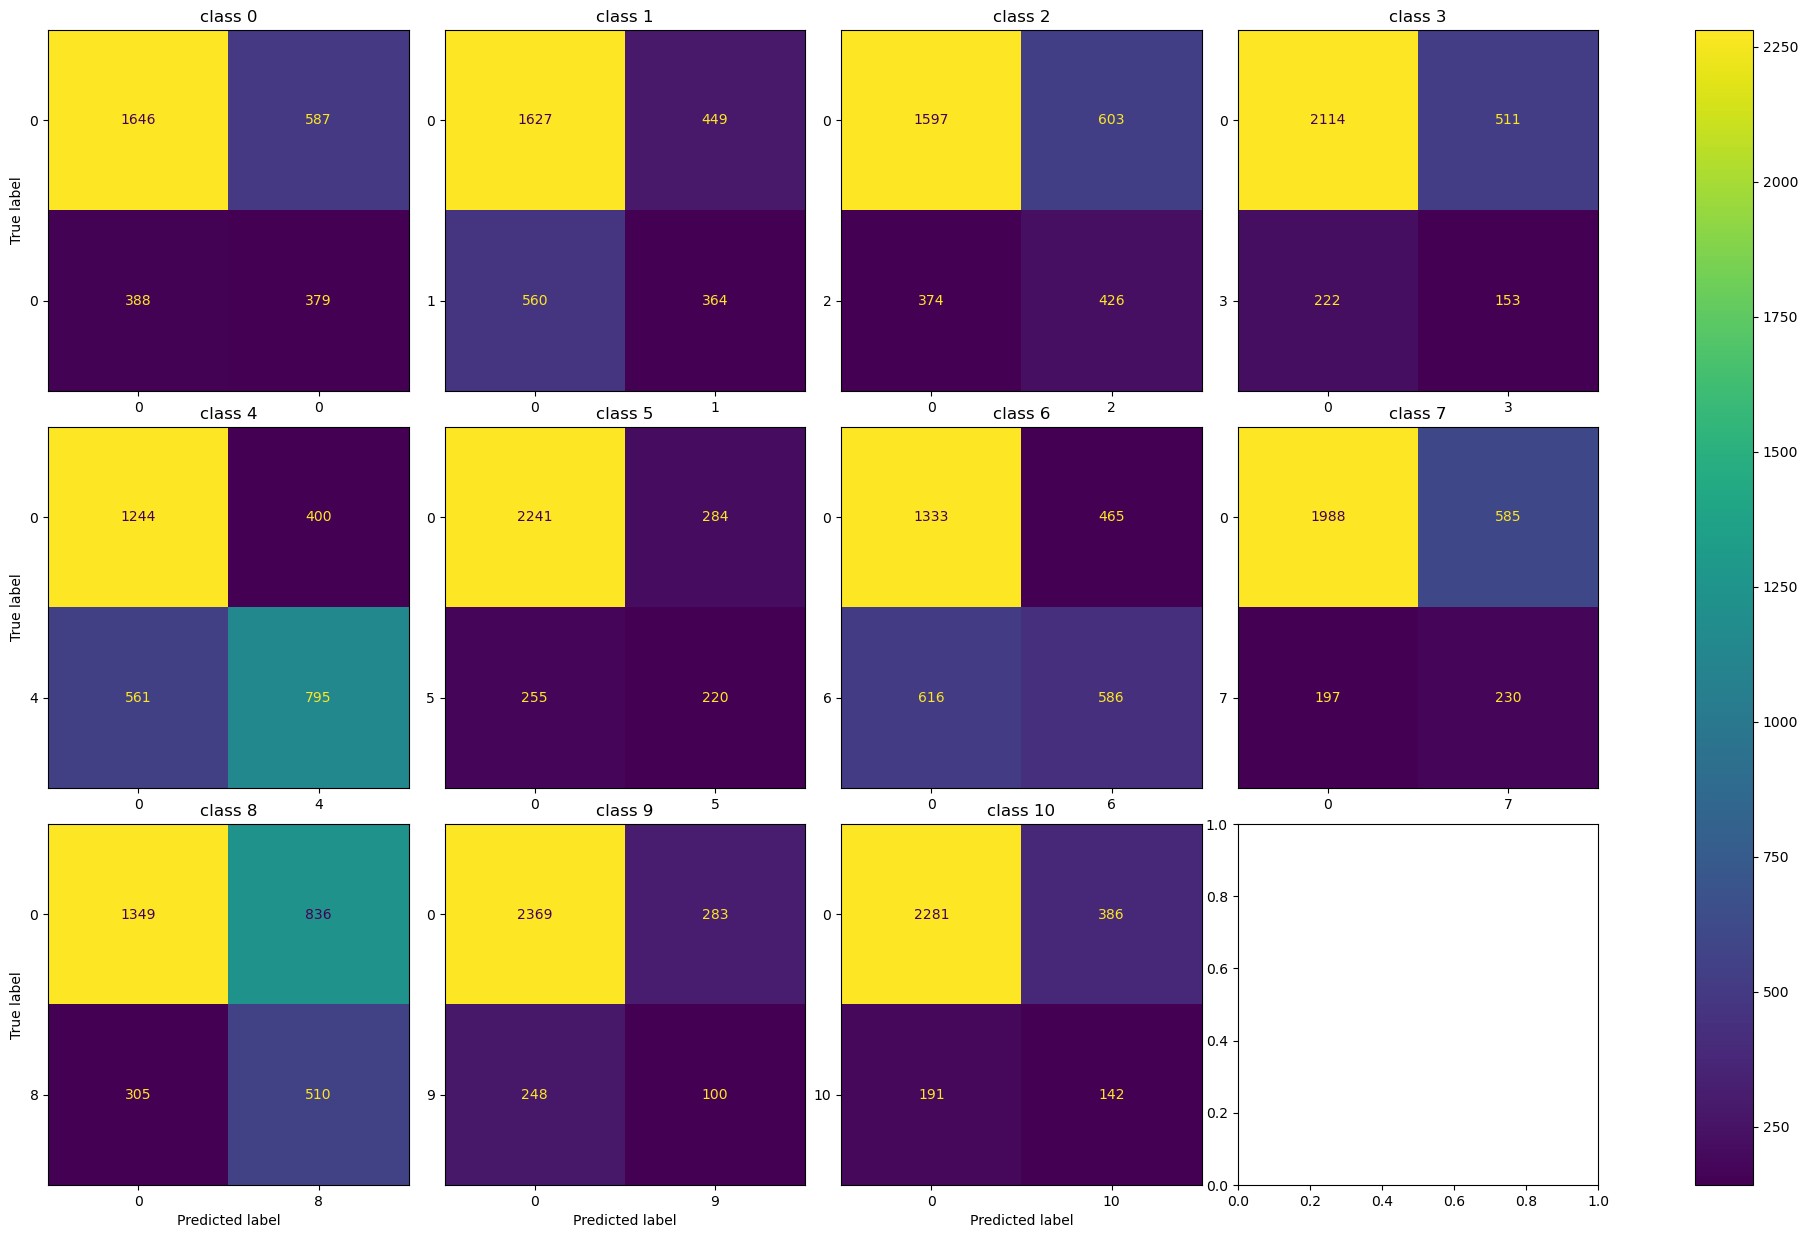

In [23]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
multilabel_confusion_matrix(preds["y_true"], preds["y_pred"])

f, axes = plt.subplots(3, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(11):
    disp = ConfusionMatrixDisplay(confusion_matrix(preds["y_true"][:, i],
                                                   preds["y_pred"][:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<8:
        disp.ax_.set_xlabel('')
    if i%4!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()


In [ ]:
loaders[0].dataset.labels.sum(0)

array([10660, 12115, 11024,  5020, 17235,  6223, 15406,  5959, 11187,
        4312,  2789])

In [ ]:
test_loader.dataset.labels.sum(0)

array([1306, 1532, 1358,  616, 2222,  803, 1966,  770, 1373,  538,  314])

In [ ]:
len(loaders[0].dataset)

43545

In [ ]:
print("Macro AUC:", roc_auc_score(preds["y_true"], preds["logits"], average="macro"))
print("Micro AUC:", roc_auc_score(preds["y_true"], preds["logits"], average="micro"))

Macro AUC: 0.6946036215903693
Micro AUC: 0.6907132844045767


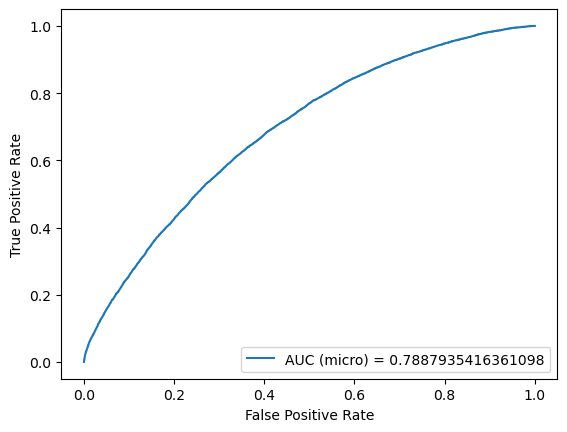

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(preds["y_true"].flatten(), preds["logits"].flatten())

plt.plot(fpr, tpr, label="AUC (micro) = 0.7887935416361098")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)

In [ ]:
y_true = torch.cat([x[1] for x in test_loader])

In [ ]:
y_prob = torch.full(y_true.shape, 0)

In [ ]:
from sklearn.metrics import mean_squared_error

stats = [mean_squared_error(y_true.flatten(), y_prob.flatten(), squared=False),
        mean_squared_error(y_true, y_prob, squared=False),
        mean_squared_error(y_true, y_prob, squared=True)]


NameError: name 'y_true' is not defined

In [ ]:
stats

[0.4132151704649745, 0.36778202626224377, 0.17074677710239794]

In [ ]:
mean_squared_error(y_true, y_prob, squared=False, multioutput="raw_values")

array([0.43603939, 0.47828673, 0.42718157, 0.16272398, 0.54828193,
       0.23683677, 0.50501227, 0.22175497, 0.35448589, 0.13362141,
       0.12985203])

In [ ]:
rows = tests.iterrows()
x = 0

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_dirs = ["."]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    print(font_file)
    font_manager.fontManager.addfont(font_file)

/home/alexlu/Documents/Programming/alexlu07/Scires/11th/model2/model/cour.ttf
/home/alexlu/Documents/Programming/alexlu07/Scires/11th/model2/model/times.ttf


In [ ]:
sns.set_theme(font="Times New Roman", style="dark")

In [ ]:
import seaborn as sns

data = sorted(zip(p[:-1], label_names[:-1]), reverse=True)

g = sns.barplot(y=[d[1] for d in data], x=[d[0] for d in data], orient="h")
# g.tick_params(axis="x", rotation=90)

NameError: name 'p' is not defined

In [ ]:
# label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]
label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]

i, row = next(rows)
text = row["text"]
probs = row.loc["0":"10"].values.astype(float)
probs = 1/(1+np.exp(-probs))
p = 1/(1+np.exp(-preds["logits"][x]))
for i in text:
    print(i)
for i in range(11):
    print(f"{probs[i]:.3f} {p[i]:.3f}", label_names[i])
x += 1

data = sorted(zip(p[:-1], label_names[:-1]), reverse=True)

g = sns.barplot(y=[d[1] for d in data], x=[d[0] for d in data], orient="h")


NameError: name 'rows' is not defined

In [ ]:
dc = DataClass(hyperparams, [
    [
        "i just lost my job today. it's devastating", 
        "i just found a job today, i'm so happy", 
        "this is miserable. i feel like a failure.", 
        "i can't believe my good fortune!",
    ], [
        "I just got a promotion at work! I'm so excited and proud of myself!",
        "Wow, that's fantastic news! Congratulations! 🎉",
        "Thanks! It's been a long journey, but I finally feel recognized for my efforts.",
        "I can imagine the hard work you've put in. Your dedication has paid off. How do you feel now?",
    ]], pred_mode=True)
dl = DataLoader(dc, batch_size=100, shuffle=False)

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


100%|██████████| 2/2 [00:00<00:00, 671.52it/s]


In [ ]:
dc = DataClass(hyperparams, [
    [
        "i just lost everything that mattered to me. there's no point in life anymore", 
        "life is meaningless anyways", 
        "what should i do now? what can i even do now", 
        "it's hopeless. there's no point in doing anything. life is sad",
    ], [
        "i just lost everything that mattered to me. there's no point in life anymore", 
        "don't worry, i got you. look at all these good things!", 
        "oh wow, thanks! what should i do now?", 
        "just stay optimistic. don't give up",
    ]], pred_mode=True)
dl = DataLoader(dc, batch_size=100, shuffle=False)

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


100%|██████████| 2/2 [00:00<00:00, 693.90it/s]


In [ ]:
logits = model.predict(next(iter(dl)), device)[2].cpu().detach().numpy()
probs = 1/(1+np.exp(-logits))[1]


In [ ]:
# label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]
label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]


for i in range(11):
    print(f"{probs[i]:.3f}", label_names[i])


0.200 anger
0.353 anticipation
0.204 disgust
0.359 fear
0.746 joy
0.720 love
0.792 optimism
0.486 hopeless
0.443 sadness
0.246 surprise
0.830 trust


In [ ]:
for d in data:
    print(d[0])

0.9889016
0.98231375
0.6492376
0.012762618
0.010274691
0.0041388157
0.001701691
0.0015901112
0.0015750561
0.0015046714
0.0013766834


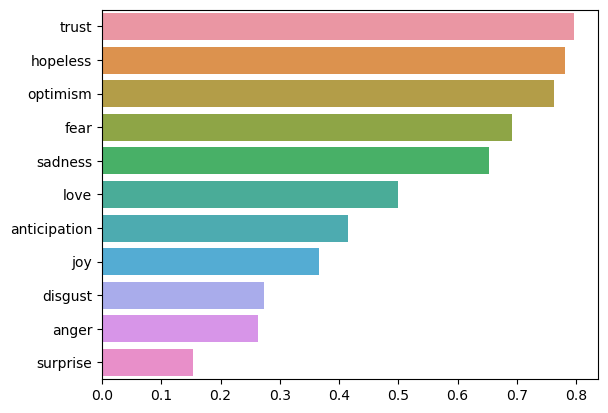

In [ ]:
data = sorted(zip(probs, label_names), reverse=True)
g = sns.barplot(y=[d[1] for d in data], x=[d[0] for d in data], orient="h")


In [ ]:
label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]

y_true = pd.DataFrame(preds['y_true'], columns=label_names)
y_pred = pd.DataFrame(preds['y_pred'], columns=label_names)
logits = pd.DataFrame(preds['logits'], columns=label_names)

correlation = "pearson"

y_true_corr = y_true.corr(correlation)
y_pred_corr = y_pred.corr(correlation)
logits_corr = logits.corr(correlation)

In [ ]:
train.loc[:, "0":"10"].sum()

0     11087
1     13725
2     10704
3      1431
4     16935
5      2995
6     15691
7      1927
8      6954
9       670
10      526
dtype: int64

In [ ]:
# _ = sns.clustermap(logits_corr, annot=False)

In [ ]:
# data = pd.read_csv("data/test.csv")

# wrongs = [(i[0], i[1].sum(), [(j, label_names[j]) for j, x in enumerate(i[1]) if x]) for i in enumerate(preds['y_true'] != preds['y_pred']) if i[1].any()]
# test_data = [(i, data['text'][i], [(j, label_names[j]) for j in range(28) if data[str(j)][i]]) for i in data.index]
# test_data = [test_data[i[0]] for i in wrongs]